# Model Optimization with Cross-Validation and Hyperparameter Tuning

This notebook implements:
1. Stratified K-Fold Cross-Validation
2. Hyperparameter Optimization using RandomizedSearchCV
3. Optimized Ensemble Model
4. Comprehensive Model Evaluation

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Model imports
from sklearn.model_selection import (
    train_test_split, 
    StratifiedKFold, 
    cross_val_score,
    RandomizedSearchCV,
    GridSearchCV
)
from sklearn.metrics import (
    accuracy_score, 
    f1_score, 
    roc_auc_score, 
    classification_report,
    confusion_matrix
)
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
import xgboost as xgb

# For hyperparameter distributions
from scipy.stats import uniform, randint

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Model persistence
import joblib
import os
from datetime import datetime

print("All libraries imported successfully!")

All libraries imported successfully!


## 1. Load and Prepare Data

In [2]:
# Load the dataset with embeddings
df = pd.read_csv('../data/processed/ecommerce_sales_with_embeddings.csv')
print(f"Dataset shape: {df.shape}")

# Split features and target
X = df.drop(columns=['success'])
y = df['success']

# Create train-test split (we'll use CV on train set)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")
print(f"Class distribution in training: {y_train.value_counts(normalize=True).to_dict()}")

Dataset shape: (1000, 797)
Training set size: (800, 796)
Test set size: (200, 796)
Class distribution in training: {1: 0.5, 0: 0.5}


## 2. Define Cross-Validation Strategy

In [3]:
# Define Stratified K-Fold for maintaining class balance
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("Cross-validation strategy: 5-Fold Stratified K-Fold")
print("This ensures each fold maintains the same class distribution as the original dataset")

Cross-validation strategy: 5-Fold Stratified K-Fold
This ensures each fold maintains the same class distribution as the original dataset


## 3. Baseline Models with Cross-Validation

First, let's evaluate the baseline models with their default/hardcoded parameters using cross-validation.

In [4]:
# Define baseline models
baseline_models = {
    'XGBoost (Baseline)': xgb.XGBClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        eval_metric='logloss',
        use_label_encoder=False
    ),
    'Neural Network (Baseline)': MLPClassifier(
        hidden_layer_sizes=(256, 128),
        activation='relu',
        solver='adam',
        max_iter=100,  # Increased from 20 to avoid convergence warning
        random_state=42,
        early_stopping=True,
        validation_fraction=0.1
    ),
    'Logistic Regression (Baseline)': LogisticRegression(
        max_iter=1000,
        random_state=42
    )
}

# Evaluate baseline models with cross-validation
baseline_scores = {}

print("Evaluating baseline models with 5-fold cross-validation...\n")
print("-" * 60)

for name, model in baseline_models.items():
    # Perform cross-validation
    cv_scores = cross_val_score(
        model, X_train, y_train,
        cv=cv_strategy,
        scoring='roc_auc',
        n_jobs=-1
    )
    
    baseline_scores[name] = {
        'mean': cv_scores.mean(),
        'std': cv_scores.std(),
        'scores': cv_scores
    }
    
    print(f"{name}:")
    print(f"  ROC-AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
    print(f"  Individual fold scores: {[f'{score:.4f}' for score in cv_scores]}")
    print("-" * 60)

Evaluating baseline models with 5-fold cross-validation...

------------------------------------------------------------
XGBoost (Baseline):
  ROC-AUC: 0.9982 (+/- 0.0074)
  Individual fold scores: ['1.0000', '1.0000', '1.0000', '1.0000', '0.9908']
------------------------------------------------------------
Neural Network (Baseline):
  ROC-AUC: 0.8237 (+/- 0.0613)
  Individual fold scores: ['0.8427', '0.7916', '0.8697', '0.8252', '0.7892']
------------------------------------------------------------
Logistic Regression (Baseline):
  ROC-AUC: 0.9982 (+/- 0.0024)
  Individual fold scores: ['0.9991', '0.9966', '1.0000', '0.9973', '0.9981']
------------------------------------------------------------


## 4. Hyperparameter Optimization for XGBoost

Using RandomizedSearchCV for efficient hyperparameter search.

In [5]:
# Define hyperparameter search space for XGBoost
xgb_param_distributions = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.29),  # 0.01 to 0.3
    'subsample': uniform(0.6, 0.4),  # 0.6 to 1.0
    'colsample_bytree': uniform(0.6, 0.4),  # 0.6 to 1.0
    'min_child_weight': randint(1, 6),
    'gamma': uniform(0, 0.5),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(0, 2)
}

# Create XGBoost model for optimization
xgb_model = xgb.XGBClassifier(
    random_state=42,
    eval_metric='logloss',
    use_label_encoder=False,
    n_jobs=-1
)

# Perform RandomizedSearchCV
print("Starting XGBoost hyperparameter optimization...")
print("This may take 5-10 minutes...\n")

xgb_random_search = RandomizedSearchCV(
    xgb_model,
    xgb_param_distributions,
    n_iter=50,  # Number of parameter combinations to try
    cv=cv_strategy,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

# Fit the random search
xgb_random_search.fit(X_train, y_train)

# Display best parameters and score
print("\n" + "="*60)
print("XGBoost Optimization Results:")
print("="*60)
print(f"Best ROC-AUC Score: {xgb_random_search.best_score_:.4f}")
print(f"\nBest Parameters:")
for param, value in xgb_random_search.best_params_.items():
    print(f"  {param}: {value:.4f}" if isinstance(value, float) else f"  {param}: {value}")

Starting XGBoost hyperparameter optimization...
This may take 5-10 minutes...

Fitting 5 folds for each of 50 candidates, totalling 250 fits

XGBoost Optimization Results:
Best ROC-AUC Score: 1.0000

Best Parameters:
  colsample_bytree: 0.9315
  gamma: 0.1784
  learning_rate: 0.0915
  max_depth: 6
  min_child_weight: 5
  n_estimators: 140
  reg_alpha: 0.2963
  reg_lambda: 0.3305
  subsample: 0.6063


## 5. Hyperparameter Optimization for Neural Network

In [6]:
# Define hyperparameter search space for Neural Network
mlp_param_distributions = {
    'hidden_layer_sizes': [
        (100,), (200,), (100, 50), (200, 100), 
        (256, 128), (256, 128, 64), (512, 256, 128)
    ],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': uniform(0.0001, 0.01),  # L2 regularization
    'learning_rate': ['constant', 'adaptive'],
    'learning_rate_init': uniform(0.001, 0.01),
    'max_iter': randint(200, 500)
}

# Create MLP model for optimization
mlp_model = MLPClassifier(
    random_state=42,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=10
)

# Perform RandomizedSearchCV
print("Starting Neural Network hyperparameter optimization...")
print("This may take 5-10 minutes...\n")

mlp_random_search = RandomizedSearchCV(
    mlp_model,
    mlp_param_distributions,
    n_iter=30,  # Fewer iterations as NN training is slower
    cv=cv_strategy,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

# Fit the random search
mlp_random_search.fit(X_train, y_train)

# Display best parameters and score
print("\n" + "="*60)
print("Neural Network Optimization Results:")
print("="*60)
print(f"Best ROC-AUC Score: {mlp_random_search.best_score_:.4f}")
print(f"\nBest Parameters:")
for param, value in mlp_random_search.best_params_.items():
    print(f"  {param}: {value:.4f}" if isinstance(value, float) else f"  {param}: {value}")

Starting Neural Network hyperparameter optimization...
This may take 5-10 minutes...

Fitting 5 folds for each of 30 candidates, totalling 150 fits

Neural Network Optimization Results:
Best ROC-AUC Score: 0.9029

Best Parameters:
  activation: relu
  alpha: 0.0024
  hidden_layer_sizes: (256, 128, 64)
  learning_rate: constant
  learning_rate_init: 0.0092
  max_iter: 432
  solver: adam


## 6. Create Optimized Ensemble Model

In [7]:
# Get the best models
best_xgb = xgb_random_search.best_estimator_
best_mlp = mlp_random_search.best_estimator_

print("Creating ensemble with optimized models...\n")

# Train best models on full training set
best_xgb.fit(X_train, y_train)
best_mlp.fit(X_train, y_train)

# Generate predictions for stacking
xgb_train_proba = best_xgb.predict_proba(X_train)[:, 1]
mlp_train_proba = best_mlp.predict_proba(X_train)[:, 1]

xgb_test_proba = best_xgb.predict_proba(X_test)[:, 1]
mlp_test_proba = best_mlp.predict_proba(X_test)[:, 1]

# Create stacked features
stack_train = np.column_stack((xgb_train_proba, mlp_train_proba))
stack_test = np.column_stack((xgb_test_proba, mlp_test_proba))

# Train meta-model with cross-validation
meta_model = LogisticRegression(max_iter=1000, random_state=42)

# Evaluate meta-model with CV
meta_cv_scores = cross_val_score(
    meta_model, stack_train, y_train,
    cv=cv_strategy,
    scoring='roc_auc',
    n_jobs=-1
)

print(f"Meta-Model CV ROC-AUC: {meta_cv_scores.mean():.4f} (+/- {meta_cv_scores.std() * 2:.4f})")

# Fit meta-model on full training set
meta_model.fit(stack_train, y_train)

# Generate final predictions
ensemble_pred = meta_model.predict(stack_test)
ensemble_proba = meta_model.predict_proba(stack_test)[:, 1]

Creating ensemble with optimized models...

Meta-Model CV ROC-AUC: 1.0000 (+/- 0.0000)


## 7. Compare All Models Performance

In [8]:
# Evaluate all models on test set
results = {}

# Baseline XGBoost
baseline_xgb = baseline_models['XGBoost (Baseline)']
baseline_xgb.fit(X_train, y_train)
baseline_xgb_pred = baseline_xgb.predict(X_test)
baseline_xgb_proba = baseline_xgb.predict_proba(X_test)[:, 1]

# Baseline MLP
baseline_mlp = baseline_models['Neural Network (Baseline)']
baseline_mlp.fit(X_train, y_train)
baseline_mlp_pred = baseline_mlp.predict(X_test)
baseline_mlp_proba = baseline_mlp.predict_proba(X_test)[:, 1]

# Optimized models predictions
opt_xgb_pred = best_xgb.predict(X_test)
opt_mlp_pred = best_mlp.predict(X_test)

# Store results
models_evaluation = {
    'XGBoost (Baseline)': {
        'predictions': baseline_xgb_pred,
        'probabilities': baseline_xgb_proba
    },
    'XGBoost (Optimized)': {
        'predictions': opt_xgb_pred,
        'probabilities': xgb_test_proba
    },
    'Neural Network (Baseline)': {
        'predictions': baseline_mlp_pred,
        'probabilities': baseline_mlp_proba
    },
    'Neural Network (Optimized)': {
        'predictions': opt_mlp_pred,
        'probabilities': mlp_test_proba
    },
    'Ensemble (Optimized)': {
        'predictions': ensemble_pred,
        'probabilities': ensemble_proba
    }
}

# Calculate metrics for all models
print("\n" + "="*80)
print("FINAL MODEL COMPARISON (Test Set Performance)")
print("="*80)
print(f"{'Model':<30} {'Accuracy':<12} {'F1-Score':<12} {'ROC-AUC':<12}")
print("-"*80)

comparison_results = {}
for name, data in models_evaluation.items():
    acc = accuracy_score(y_test, data['predictions'])
    f1 = f1_score(y_test, data['predictions'])
    roc_auc = roc_auc_score(y_test, data['probabilities'])
    
    comparison_results[name] = {
        'accuracy': acc,
        'f1_score': f1,
        'roc_auc': roc_auc
    }
    
    print(f"{name:<30} {acc:<12.4f} {f1:<12.4f} {roc_auc:<12.4f}")

print("="*80)

# Calculate improvements
print("\n" + "="*80)
print("IMPROVEMENTS FROM OPTIMIZATION")
print("="*80)

xgb_improvement = (
    (comparison_results['XGBoost (Optimized)']['roc_auc'] - 
     comparison_results['XGBoost (Baseline)']['roc_auc']) / 
    comparison_results['XGBoost (Baseline)']['roc_auc'] * 100
)

mlp_improvement = (
    (comparison_results['Neural Network (Optimized)']['roc_auc'] - 
     comparison_results['Neural Network (Baseline)']['roc_auc']) / 
    comparison_results['Neural Network (Baseline)']['roc_auc'] * 100
)

print(f"XGBoost ROC-AUC Improvement: {xgb_improvement:+.2f}%")
print(f"Neural Network ROC-AUC Improvement: {mlp_improvement:+.2f}%")
print("="*80)


FINAL MODEL COMPARISON (Test Set Performance)
Model                          Accuracy     F1-Score     ROC-AUC     
--------------------------------------------------------------------------------
XGBoost (Baseline)             1.0000       1.0000       1.0000      
XGBoost (Optimized)            1.0000       1.0000       1.0000      
Neural Network (Baseline)      0.7300       0.7632       0.8520      
Neural Network (Optimized)     0.6250       0.6637       0.7250      
Ensemble (Optimized)           1.0000       1.0000       1.0000      

IMPROVEMENTS FROM OPTIMIZATION
XGBoost ROC-AUC Improvement: +0.00%
Neural Network ROC-AUC Improvement: -14.91%


## 9. Feature Importance Analysis (Optimized XGBoost)

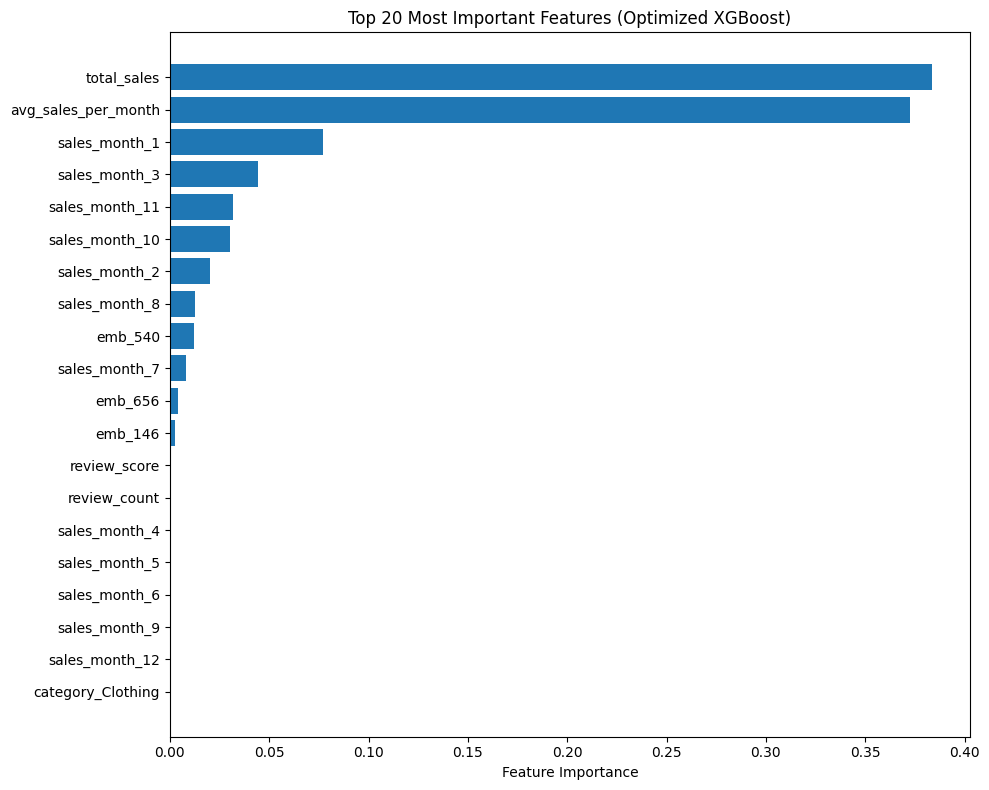


Top 10 Most Important Features:
            feature  importance
        total_sales    0.383647
avg_sales_per_month    0.372408
      sales_month_1    0.077118
      sales_month_3    0.044510
     sales_month_11    0.031944
     sales_month_10    0.030393
      sales_month_2    0.020142
      sales_month_8    0.012786
            emb_540    0.012268
      sales_month_7    0.008035


In [9]:
# Get feature importance from optimized XGBoost
feature_importance = best_xgb.feature_importances_
feature_names = X.columns

# Create DataFrame for better visualization
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False).head(20)

# Plot feature importance
plt.figure(figsize=(10, 8))
plt.barh(importance_df['feature'], importance_df['importance'])
plt.xlabel('Feature Importance')
plt.title('Top 20 Most Important Features (Optimized XGBoost)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\nTop 10 Most Important Features:")
print(importance_df.head(10).to_string(index=False))

## 10. Save Optimized Models and Results

In [10]:
# Create directory for optimized models
optimized_dir = '../models/optimized'
os.makedirs(optimized_dir, exist_ok=True)

# Save optimized models
model_files = {
    'xgboost_optimized.pkl': best_xgb,
    'neural_network_optimized.pkl': best_mlp,
    'meta_model_optimized.pkl': meta_model
}

for filename, model in model_files.items():
    filepath = os.path.join(optimized_dir, filename)
    joblib.dump(model, filepath)
    print(f"Saved: {filepath}")

# Save hyperparameters and results
optimization_results = {
    'timestamp': datetime.now().isoformat(),
    'cv_strategy': '5-fold Stratified K-Fold',
    'xgboost': {
        'best_params': xgb_random_search.best_params_,
        'cv_score': xgb_random_search.best_score_,
        'test_performance': comparison_results['XGBoost (Optimized)']
    },
    'neural_network': {
        'best_params': mlp_random_search.best_params_,
        'cv_score': mlp_random_search.best_score_,
        'test_performance': comparison_results['Neural Network (Optimized)']
    },
    'ensemble': {
        'cv_score': meta_cv_scores.mean(),
        'test_performance': comparison_results['Ensemble (Optimized)']
    },
    'improvements': {
        'xgboost_roc_auc_improvement': f"{xgb_improvement:+.2f}%",
        'neural_network_roc_auc_improvement': f"{mlp_improvement:+.2f}%"
    }
}

# Save results as JSON
import json
results_path = os.path.join(optimized_dir, 'optimization_results.json')
with open(results_path, 'w') as f:
    json.dump(optimization_results, f, indent=4, default=str)
print(f"\nSaved optimization results: {results_path}")

print("\n" + "="*60)
print("✅ Model optimization complete!")
print("="*60)
print(f"Best Model: Ensemble (Optimized)")
print(f"ROC-AUC Score: {comparison_results['Ensemble (Optimized)']['roc_auc']:.4f}")
print(f"All optimized models saved in: {optimized_dir}")

Saved: ../models/optimized\xgboost_optimized.pkl
Saved: ../models/optimized\neural_network_optimized.pkl
Saved: ../models/optimized\meta_model_optimized.pkl

Saved optimization results: ../models/optimized\optimization_results.json

✅ Model optimization complete!
Best Model: Ensemble (Optimized)
ROC-AUC Score: 1.0000
All optimized models saved in: ../models/optimized
